In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [2]:
data_raw = pd.read_csv("data.csv", encoding='latin1')
to_keep = ['dec',
            'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1',
            'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
            'gender', 'age','age_o', 'race', 'race_o', 'samerace',
            'int_corr']
len(to_keep)
data = data_raw[to_keep]

In [3]:
nullItems = data.isnull().sum()
colsNullItems = nullItems.index.tolist()   #get the column names for the
#This block finds replacement values for categorical features
    # using the mode of the columns for the purely categorical features
dataMode = data.mode()  #mode for each of the columns for data1
dataMode = dataMode.squeeze()
categorical = ['gender', 'age','age_o', 'race', 'race_o', 'samerace']
replacements = {}
    #replacements is a dictionary where {col name: mode or median value for null replacement)
for i in range(0, len(nullItems)):
    if nullItems[i] != 0:
        if to_keep[i] in categorical:  #when there are null items in a column
            replacements[colsNullItems[i]] = dataMode[i]

In [4]:
for key in replacements:
    #replace all of the purely categorical null elements with the mode of the column
    data[key]= data[key].fillna(value = replacements[key])

<ipython-input-4-20ef6611c2b1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[key]= data[key].fillna(value = replacements[key])


In [5]:
# Replace the continuous/numerical values use KNN replacement
imputer = KNNImputer(n_neighbors=100)
df_filled = imputer.fit_transform(data)
    #use the KNN imputer to input replacement vals for null values in the continuous data columns
df_filled_pd = pd.DataFrame(df_filled, columns = data.columns.tolist())

data = pd.DataFrame(df_filled, columns = data.columns.tolist())  # data is now full

In [6]:
# split dataset into features and label
y = data['dec']
x = data.drop('dec', axis=1)

In [7]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=334)

In [8]:
# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [9]:
# find variance of data
original_var = np.var(x_train, axis=0)
sum_o_var = np.sum(original_var)
sum_o_var

0.8959990836782443

In [10]:
# perform PCA on data, find number of components needed to capture 95% of variance of original dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=13)
x_train_pca = pca.fit_transform(x_train)
pca_var = np.var(x_train_pca, axis=0)
sum_p_var = np.sum(pca_var)
sum_p_var/sum_o_var

0.9539453745554455

In [11]:
x_train = x_train_pca
x_test = pca.transform(x_test)

In [12]:
# Do K Fold Cross Validation on K Nearest Neighbors model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

acc = []
k_values = list(range(1,201))

for k in k_values:
    kf = KFold(n_splits=10, shuffle=True, random_state=334)
    model = KNeighborsClassifier(n_neighbors=k)

    acc_score = []

    for train_index, test_index in kf.split(x_train):
        x_ktrain , x_ktest = x_train[train_index,:],x_train[test_index,:]
        y_ktrain , y_ktest = y_train.iloc[train_index] , y_train.iloc[test_index]

        model.fit(x_ktrain, y_ktrain)
        pred_k = model.predict(x_ktest)

        acc_score.append(accuracy_score(pred_k, y_ktest))

    avg_acc = sum(acc_score) / 10
    acc.append(avg_acc)

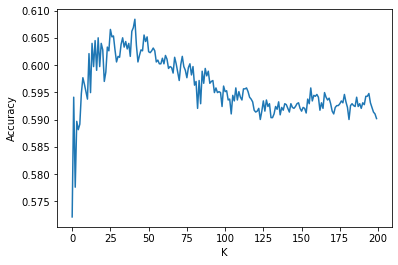

In [13]:
# Plot KNN accuracy
plt.plot(acc)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.savefig("knn.png", format="png")

In [14]:
# Identify optimal value
k_values[np.argmax(acc)]

42

In [15]:
# Find test accuracy
knn = KNeighborsClassifier(n_neighbors = 42)
knn.fit(x_train_pca, y_train)
pred = knn.predict(x_test)
accuracy_score(pred, y_test)

0.6157517899761337

In [16]:
# K Fold Cross Validation on Logistic Regression
from sklearn.linear_model import LogisticRegression

acc = []

for c in [10**x for x in range(10, -10, -1)]:
    kf = KFold(n_splits=10, shuffle=True, random_state=334)
    model = LogisticRegression(C=c)

    acc_score = []

    for train_index, test_index in kf.split(x_train_pca):
        x_ctrain , x_ctest = x_train_pca[train_index,:],x_train_pca[test_index,:]
        y_ctrain , y_ctest = y_train.iloc[train_index] , y_train.iloc[test_index]

        model.fit(x_ctrain, y_ctrain)
        pred_c = model.predict(x_ktest)

        acc_score.append(accuracy_score(pred_c, y_ctest))

    avg_acc = sum(acc_score) / 10
    acc.append(avg_acc)

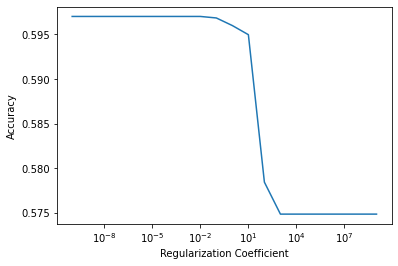

In [17]:
#Plot accuracy
plt.plot([0.1**x for x in range(10, -10, -1)], acc)
plt.xscale("log")
plt.xlabel("Regularization Coefficient")
plt.ylabel("Accuracy")
plt.savefig("lr.png", format="png")

In [19]:
# Accuracy when no regularization
kf = KFold(n_splits=10, shuffle=True, random_state=334)
model = LogisticRegression(penalty='none')

acc_score = []

for train_index, test_index in kf.split(x_train_pca):
    x_ctrain , x_ctest = x_train_pca[train_index,:],x_train_pca[test_index,:]
    y_ctrain , y_ctest = y_train.iloc[train_index] , y_train.iloc[test_index]

    model.fit(x_ctrain, y_ctrain)
    pred_c = model.predict(x_ctest)

    acc_score.append(accuracy_score(pred_c, y_ctest))

avg_acc = sum(acc_score) / 10
avg_acc # No regularization needed

0.5970207743428434

In [48]:
# Logistic Regression Test Accuracy
model = LogisticRegression(penalty='none')
model.fit(x_train_pca, y_train)
pred = model.predict(x_test)
accuracy_score(pred, y_test)

0.609387430389817

In [76]:
# K Fold Cross Validation on Decision Tree, testing max depth between 1 and 100
from sklearn.tree import DecisionTreeClassifier

acc = []
depth_values = [x for x in range(1,100)]

for depth in depth_values:
    kf = KFold(n_splits=10, shuffle=True, random_state=334)
    model = DecisionTreeClassifier(criterion='entropy', max_depth=depth)

    acc_score = []

    for train_index, test_index in kf.split(x_train_pca):
        x_dtrain , x_dtest = x_train_pca[train_index,:],x_train_pca[test_index,:]
        y_dtrain , y_dtest = y_train.iloc[train_index] , y_train.iloc[test_index]

        model.fit(x_dtrain, y_dtrain)
        pred_k = model.predict(x_dtest)

        acc_score.append(accuracy_score(pred_k, y_dtest))

    avg_acc = sum(acc_score) / 10
    acc.append(avg_acc)

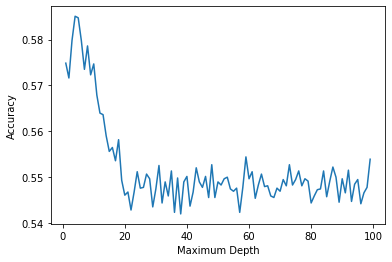

In [77]:
#Plot accuracy
plt.plot(depth_values, acc)
plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy")
plt.savefig("dt1.png", format="png")

In [78]:
# Identify optimal value
depth_values[np.argmax(acc)]

4

In [79]:
# K Fold Cross Validation on Decision Tree, testing min samples leaf between 1 to 100, incrementing by 1
acc = []
min_samples_values = [x for x in range(1, 100)]

for samples in min_samples_values:
    kf = KFold(n_splits=10, shuffle=True, random_state=334)
    model = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=samples)

    acc_score = []

    for train_index, test_index in kf.split(x_train_pca):
        x_strain , x_stest = x_train_pca[train_index,:],x_train_pca[test_index,:]
        y_strain , y_stest = y_train.iloc[train_index] , y_train.iloc[test_index]

        model.fit(x_strain, y_strain)
        pred_s = model.predict(x_stest)

        acc_score.append(accuracy_score(pred_s, y_stest))

    avg_acc = sum(acc_score) / 10
    acc.append(avg_acc)

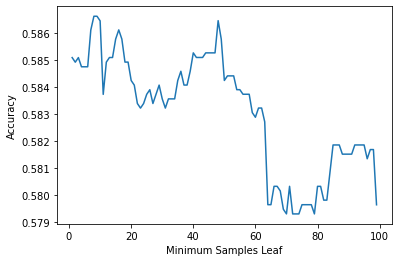

In [84]:
#Plot accuracy
plt.plot(min_samples_values, acc)
plt.xlabel("Minimum Samples Leaf")
plt.ylabel("Accuracy")
plt.savefig("dt2.png", format="png")

In [81]:
# Identify optimal value
min_samples_values[np.argmax(acc)]

8

In [83]:
# Decision Tree Test Accuracy
model = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=8)
model.fit(x_train_pca, y_train)
pred = model.predict(x_test)
accuracy_score(pred, y_test)

0.5950676213206046

In [56]:
# K Fold Cross Validation on Gradient Boost, testing number of estimators between 1 and 100, incrementing by 1
from xgboost import XGBClassifier

acc = []
estimator_values = [x for x in range(1, 100)]

for estimator in estimator_values:
    kf = KFold(n_splits=10, shuffle=True, random_state=334)
    model = XGBClassifier(n_estimators=estimator)

    acc_score = []

    for train_index, test_index in kf.split(x_train_pca):
        x_ntrain , x_ntest = x_train_pca[train_index,:],x_train_pca[test_index,:]
        y_ntrain , y_ntest = y_train.iloc[train_index] , y_train.iloc[test_index]

        model.fit(x_ntrain, y_ntrain)
        pred_n = model.predict(x_ntest)

        acc_score.append(accuracy_score(pred_n, y_ntest))

    avg_acc = sum(acc_score) / 10
    acc.append(avg_acc)

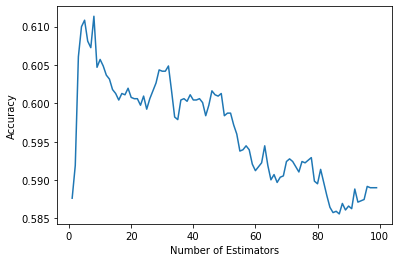

In [57]:
#Plot accuracy
plt.plot(estimator_values, acc)
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.savefig("gb1.png", format="png")

In [58]:
# Identify optimal value
estimator_values[np.argmax(acc)]

8

In [59]:
# K Fold Cross Validation on Gradient Boost, testing maximum depth between 1 and 50
from xgboost import XGBClassifier

acc = []
depth_values = [x for x in range(1, 50)]

for depth in depth_values:
    kf = KFold(n_splits=10, shuffle=True, random_state=334)
    model = XGBClassifier(n_estimators=8, max_depth=depth)

    acc_score = []

    for train_index, test_index in kf.split(x_train_pca):
        x_dtrain , x_dtest = x_train_pca[train_index,:],x_train_pca[test_index,:]
        y_dtrain , y_dtest = y_train.iloc[train_index] , y_train.iloc[test_index]

        model.fit(x_dtrain, y_dtrain)
        pred_d = model.predict(x_dtest)

        acc_score.append(accuracy_score(pred_d, y_dtest))

    avg_acc = sum(acc_score) / 10
    acc.append(avg_acc)

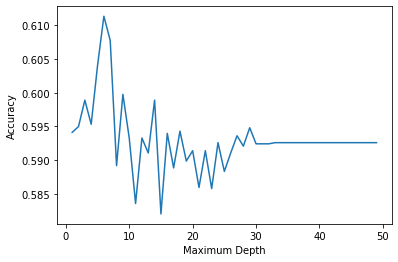

In [61]:
#Plot accuracy
plt.plot(depth_values, acc)
plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy")
plt.savefig("gb2.png", format="png")

In [62]:
# Identify optimal value
depth_values[np.argmax(acc)]

6

In [66]:
# K Fold Cross Validation on Gradient Boost, testing learning rate
from xgboost import XGBClassifier

acc = []
rate_values = [x/100 for x in range(1,100)]

for rate in rate_values:
    kf = KFold(n_splits=10, shuffle=True, random_state=334)
    model = XGBClassifier(n_estimators=8, max_depth=6, learning_rate=rate)

    acc_score = []

    for train_index, test_index in kf.split(x_train_pca):
        x_rtrain , x_rtest = x_train_pca[train_index,:],x_train_pca[test_index,:]
        y_rtrain , y_rtest = y_train.iloc[train_index] , y_train.iloc[test_index]

        model.fit(x_rtrain, y_rtrain)
        pred_r = model.predict(x_rtest)

        acc_score.append(accuracy_score(pred_r, y_rtest))

    avg_acc = sum(acc_score) / 10
    acc.append(avg_acc)

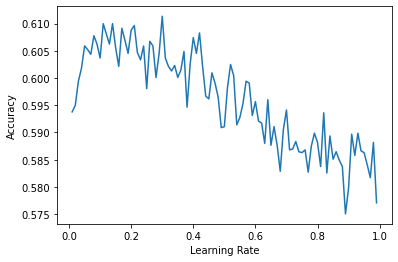

In [67]:
#Plot accuracy
plt.plot(rate_values, acc)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.savefig("gb3.png", format="png")

In [69]:
# K Fold Cross Validation on Gradient Boost, testing regularization term
from xgboost import XGBClassifier

acc = []
reg_values = [x/100 for x in range(1,100)]

for reg in reg_values:
    kf = KFold(n_splits=10, shuffle=True, random_state=334)
    model = XGBClassifier(n_estimators=8, max_depth=6, learning_rate=0.15, reg_lambda=reg)

    acc_score = []

    for train_index, test_index in kf.split(x_train_pca):
        x_rtrain , x_rtest = x_train_pca[train_index,:],x_train_pca[test_index,:]
        y_rtrain , y_rtest = y_train.iloc[train_index] , y_train.iloc[test_index]

        model.fit(x_rtrain, y_rtrain)
        pred_r = model.predict(x_rtest)

        acc_score.append(accuracy_score(pred_r, y_rtest))

    avg_acc = sum(acc_score) / 10
    acc.append(avg_acc)

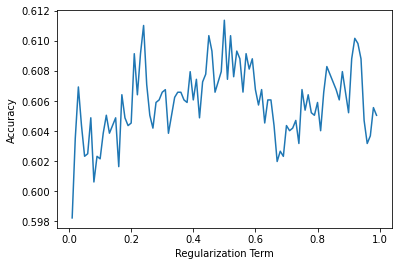

In [70]:
#Plot accuracy
plt.plot(reg_values, acc)
plt.xlabel("Regularization Term")
plt.ylabel("Accuracy")
plt.savefig("gb4.png", format="png")

In [71]:
# Identify optimal value
reg_values[np.argmax(acc)]

0.5

In [72]:
# Retesting number of estimators between 1 and 100
acc = []
estimator_values = [x for x in range(1, 100)]

for estimator in estimator_values:
    kf = KFold(n_splits=10, shuffle=True, random_state=334)
    model = XGBClassifier(n_estimators=estimator, max_depth=6, learning_rate=0.15, reg_lambda=0.5)

    acc_score = []

    for train_index, test_index in kf.split(x_train_pca):
        x_ntrain , x_ntest = x_train_pca[train_index,:],x_train_pca[test_index,:]
        y_ntrain , y_ntest = y_train.iloc[train_index] , y_train.iloc[test_index]

        model.fit(x_ntrain, y_ntrain)
        pred_n = model.predict(x_ntest)

        acc_score.append(accuracy_score(pred_n, y_ntest))

    avg_acc = sum(acc_score) / 10
    acc.append(avg_acc)

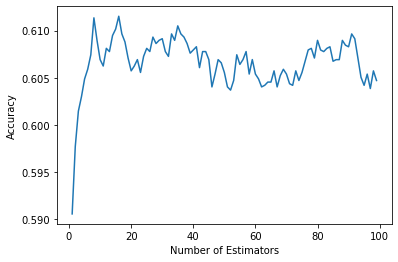

In [73]:
#Plot accuracy
plt.plot(estimator_values, acc)
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.savefig("gb5.png", format="png")

In [74]:
# Identify optimal value
estimator_values[np.argmax(acc)]

16

In [75]:
# Decision Tree Test Accuracy
model = XGBClassifier(n_estimators=18, max_depth=6, learning_rate=0.15, reg_lambda=0.5)
model.fit(x_train_pca, y_train)
pred = model.predict(x_test)
accuracy_score(pred, y_test)

0.6026252983293556